In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab \Notebooks/Mahdi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Mahdi


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import shutil

#Add Additional libraries here
from torchvision import transforms as transforms
from skimage.util import montage
import cv2 
import matplotlib.pyplot as plt 
import torch.optim as optim
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import vgg19,resnet50
import seaborn as sns
import torch.nn.functional as F

random.seed(0)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
!git clone https://github.com/UCSD-AI4H/COVID-CT

fatal: destination path 'COVID-CT' already exists and is not an empty directory.


In [4]:
%cd COVID-CT/Images-processed/

/content/drive/MyDrive/Colab Notebooks/Mahdi/COVID-CT/Images-processed


In [5]:
!unzip CT_COVID.zip
!unzip CT_NonCOVID.zip

Archive:  CT_COVID.zip
replace CT_COVID/2020.03.01.20029769-p21-73_1%1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  CT_NonCOVID.zip
replace CT_NonCOVID/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
#cd back to the main folder
%cd ..

/content/drive/MyDrive/Colab Notebooks/Mahdi/COVID-CT


In [7]:
covid_files_path = 'Images-processed/CT_COVID/'
covid_files      = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
non_covid_files_path = 'Images-processed/CT_NonCOVID/'
non_covid_files      = [os.path.join(non_covid_files_path, x) for x in os.listdir(non_covid_files_path)]

In [8]:
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 3)]
non_covid_images = [cv2.imread(x) for x in random.sample(non_covid_files, 3)]

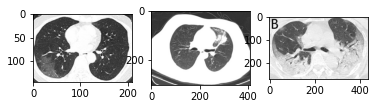

In [9]:
for i, image in enumerate(covid_images):
    plt.subplot(len(covid_images) / 3+1, 3, i + 1)
    plt.imshow(image)

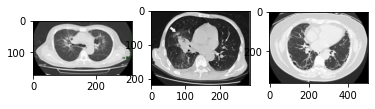

In [10]:
for i, image in enumerate(non_covid_images):
    plt.subplot(len(non_covid_images) / 3 + 1, 3, i + 1)
    plt.imshow(image)

In [11]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [12]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, classes, covid_files, non_covid_files, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.files_path = [non_covid_files, covid_files]
        self.image_list = []

        # read the files from data split text files
        covid_files = read_txt(covid_files)
        non_covid_files = read_txt(non_covid_files)

        # combine the positive and negative files into a cummulative files list
        for cls_index in range(len(self.classes)):
            
            class_files = [[os.path.join(self.root_dir, self.classes[cls_index], x), cls_index] \
                            for x in read_txt(self.files_path[cls_index])]
            self.image_list += class_files
                
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        path = self.image_list[idx][0]
        
        # Read the image
        image = Image.open(path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)

        label = int(self.image_list[idx][1])

        data = {'img':   image,
                'label': label,
                'paths' : path}

        return data

In [13]:
#The normalization article refers to these numbers mean=[0.485, 0.456, 0.406] and standard = [0.229, 0.224, 0.225]

In [14]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [15]:
train_transformer = transforms.Compose([
    transforms.Resize(224),  
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

In [16]:
val_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [17]:
batchsize = 8

trainset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/trainCT_COVID.txt',
                          non_covid_files='Data-split/NonCOVID/trainCT_NonCOVID.txt',
                          transform= train_transformer)
valset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/valCT_COVID.txt',
                          non_covid_files = 'Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform= val_transformer)
testset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/testCT_COVID.txt',
                          non_covid_files='Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform= val_transformer)

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

In [18]:
model = resnet50(pretrained=True)

In [19]:
# model.classifier[6] = nn.Linear(in_features=4096, out_features=2);
model.to(device);

In [20]:
def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())

        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({}%)] \t Train Loss: {}'.format(epoch, batch_index, len(train_loader),100.0 * batch_index / len(train_loader), loss.item() / bs))
    
    print('\n Train set: Average loss: {}, Accuracy: {}/{} ({}%)\n'.format(train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),100.0 * train_correct / len(train_loader.dataset)))

In [21]:
def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
          
    return targetlist, scorelist, predlist

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [23]:
bs = 10
votenum = 10
# import warnings
# warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []

vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

In [24]:
#number epoch
total_epoch = 100

In [25]:
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)

    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
        
        
        # #if epoch == total_epoch:
        # torch.save(model.state_dict(), "model_backup/{}.pt".format(modelname))  
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {}, average precision: {},average F1: {}, average accuracy: {}, average AUC: {}'.format(epoch, r, p, F1, acc, AUC))


Train Epoch: 1 [0/54 (0.0%)] 	 Train Loss: 0.883992862701416
Train Epoch: 1 [10/54 (18.51851851851852%)] 	 Train Loss: 0.5309305667877198
Train Epoch: 1 [20/54 (37.03703703703704%)] 	 Train Loss: 0.4471578121185303
Train Epoch: 1 [30/54 (55.55555555555556%)] 	 Train Loss: 0.08889859914779663
Train Epoch: 1 [40/54 (74.07407407407408%)] 	 Train Loss: 0.19574081897735596
Train Epoch: 1 [50/54 (92.5925925925926%)] 	 Train Loss: 0.14797719717025756

 Train set: Average loss: 0.4078804850578308, Accuracy: 231/425 (54.35294117647059%)

Train Epoch: 2 [0/54 (0.0%)] 	 Train Loss: 0.018654680252075194
Train Epoch: 2 [10/54 (18.51851851851852%)] 	 Train Loss: 0.042966237664222716
Train Epoch: 2 [20/54 (37.03703703703704%)] 	 Train Loss: 0.030092856287956236
Train Epoch: 2 [30/54 (55.55555555555556%)] 	 Train Loss: 0.008714397996664047
Train Epoch: 2 [40/54 (74.07407407407408%)] 	 Train Loss: 0.03152499198913574
Train Epoch: 2 [50/54 (92.5925925925926%)] 	 Train Loss: 0.007695122063159943

 Train 

In [26]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)

            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)

            correct += pred.eq(target.long().view_as(pred)).sum().item()
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist

In [27]:
r_list = []
p_list = []
acc_list = []
AUC_list = []

vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())

for epoch in range(1, total_epoch+1):
    
    targetlist, scorelist, predlist = test(epoch)
#     print('target',targetlist)
#     print('score',scorelist)
#     print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 
    
    TP = ((predlist == 1) & (targetlist == 1)).sum()
    TN = ((predlist == 0) & (targetlist == 0)).sum()
    FN = ((predlist == 0) & (targetlist == 1)).sum()
    FP = ((predlist == 1) & (targetlist == 0)).sum()

    print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
    print('TP+FP',TP+FP)
    p = TP / (TP + FP)
    print('precision',p)
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    print('recall',r)
    F1 = 2 * r * p / (r + p)
    acc = (TP + TN) / (TP + TN + FP + FN)
    print('F1',F1)
    print('acc',acc)
    AUC = roc_auc_score(targetlist, vote_score)
    print('AUC', AUC)
    print(30*'-')

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        

        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUC', AUC)
        
        
        
        vote_pred = np.zeros((1,testset.__len__()))
        vote_score = np.zeros(testset.__len__())
        print('\n vote_pred',vote_pred)
        print('\n The epoch is {}, average recall: {}, average precision: {},average F1: {}, average accuracy: {}, average AUC: {}'.format(epoch, r, p, F1, acc, AUC))



TP= 77 TN= 76 FN= 21 FP= 29
TP+FP 106
precision 0.7264150943396226
recall 0.7857142857142857
F1 0.7549019607843137
acc 0.7536945812807881
AUC 0.8549076773566568
------------------------------
TP= 77 TN= 76 FN= 21 FP= 29
TP+FP 106
precision 0.7264150943396226
recall 0.7857142857142857
F1 0.7549019607843137
acc 0.7536945812807881
AUC 0.8549076773566568
------------------------------
TP= 77 TN= 76 FN= 21 FP= 29
TP+FP 106
precision 0.7264150943396226
recall 0.7857142857142857
F1 0.7549019607843137
acc 0.7536945812807881
AUC 0.8549076773566568
------------------------------
TP= 77 TN= 76 FN= 21 FP= 29
TP+FP 106
precision 0.7264150943396226
recall 0.7857142857142857
F1 0.7549019607843137
acc 0.7536945812807881
AUC 0.8549076773566568
------------------------------
TP= 77 TN= 76 FN= 21 FP= 29
TP+FP 106
precision 0.7264150943396226
recall 0.7857142857142857
F1 0.7549019607843137
acc 0.7536945812807881
AUC 0.8549076773566568
------------------------------
TP= 77 TN= 76 FN= 21 FP= 29
TP+FP 106
pr